In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import sys
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import os
from tensorflow.keras.utils import Sequence
k_size = 3

# Part 1 - Data Preprocessing 

In [2]:
class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """

    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):

        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(os.path.join(base_path, "gt_image"))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id) / float(self.batch_size)))

    def __load__(self, id_name):
        image_path = os.path.join(self.base_path, "gt_image", (id_name ))
        label_path = os.path.join(self.base_path, "gt_binary_image", (id_name ))
        #print(image_path)
        image = cv2.imread(image_path, 1)  # Reading Image in RGB format
        image = cv2.resize(image, (self.img_size, self.img_size))
        # image = cv2.resize(image, (int(img.shape[1]/2), int(img.shape[0]/2)))
        #print(label_path)
        mask = cv2.imread(label_path, 1)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        # mask = cv2.resize(mask, (int(img.shape[1]/2), int(img.shape[0]/2)))

        # Normalizing the image
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.id):
            file_batch = self.id[index * self.batch_size:]
        else:
            file_batch = self.id[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for id_name in file_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)




# Part 2 - Model

In [3]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c
def ResUNet(img_h =256, img_w=256):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Evaluation Metrics

In [4]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        
        return iou

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)



def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice
    

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# COMPILING MODEL

In [5]:

model = ResUNet()

checkpoint = ModelCheckpoint(r"C:\TUsimple_ResUNet\model", verbose=1, monitor ='val_loss',  save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
callbacks = [ checkpoint, reduce_lr]

opt = tf.keras.optimizers.experimental.Adam(1e-3)
metrics = [f1, iou , dice_coef ]

model.compile(loss=dice_coef_loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

train_generator = DataGenerator2D(r"E:\NU\TUsimple\train_set\training", img_size=256, batch_size=10, shuffle=True)
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256, batch_size=10, shuffle=False)

# Part 3 - Training

history = model.fit(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=20,
                              validation_steps=10,
                              epochs=100,
                              callbacks=callbacks)

print(history.history.keys())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 128)  73856       ['add_2[0][0]']                  
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 128)  512        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 batch_normalization_19 (BatchN  (None, 64, 64, 320)  1280       ['concatenate_1[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 320)  0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 128)  368768      ['activation_13[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 64, 64, 128)  512        ['conv2d_20[0][0]']              
 ormalization)                                                                                    
          

 conv2d_27 (Conv2D)             (None, 256, 256, 32  9248        ['activation_18[0][0]']          
                                )                                                                 
                                                                                                  
 add_8 (Add)                    (None, 256, 256, 32  0           ['batch_normalization_27[0][0]', 
                                )                                 'conv2d_27[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 1)  33          ['add_8[0][0]']                  
                                                                                                  
Total params: 6,287,729
Trainable params: 6,280,433
Non-trainable params: 7,296
__________________________________________________________________________________________________
Epoch 1/100
20/20 [==========

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 39s 921ms/step - loss: 0.6851 - f1: 0.3223 - iou: 0.1970 - dice_coef: 0.3149 - val_loss: 0.8959 - val_f1: 0.1045 - val_iou: 0.0550 - val_dice_coef: 0.1041 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.4387 - f1: 0.5692 - iou: 0.4036 - dice_coef: 0.5613
Epoch 2: val_loss improved from 0.89590 to 0.88704, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 896ms/step - loss: 0.4387 - f1: 0.5692 - iou: 0.4036 - dice_coef: 0.5613 - val_loss: 0.8870 - val_f1: 0.1128 - val_iou: 0.0599 - val_dice_coef: 0.1130 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.3543 - f1: 0.6543 - iou: 0.4976 - dice_coef: 0.6457
Epoch 3: val_loss did not improve from 0.88704
20/20 [==============================] - 10s 471ms/step - loss: 0.3543 - f1: 0.6543 - iou: 0.4976 - dice_coef: 0.6457 - val_loss: 0.8922 - val_f1: 0.1070 - val_iou: 0.0570 - val_dice_coef: 0.1078 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.3379 - f1: 0.6723 - iou: 0.5169 - dice_coef: 0.6621
Epoch 4: val_loss did not improve from 0.88704
20/20 [==============================] - 10s 483ms/step - loss: 0.3379 - f1: 0.6723 - iou: 0.5169 - dice_coef: 0.6621 - val_loss: 0.9529 - val_f1: 0.0096 - val_iou: 0.0245 - val_dice_coef: 0.0471 - lr: 0.0010
Epoch 5/100
20/20 [==============

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 856ms/step - loss: 0.0990 - f1: 0.9039 - iou: 0.8437 - dice_coef: 0.9010 - val_loss: 0.8562 - val_f1: 0.1420 - val_iou: 0.0847 - val_dice_coef: 0.1438 - lr: 1.2500e-04
Epoch 15/100
20/20 [==============================] - ETA: 0s - loss: 0.0970 - f1: 0.9036 - iou: 0.8558 - dice_coef: 0.9030
Epoch 15: val_loss improved from 0.85618 to 0.81183, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 830ms/step - loss: 0.0970 - f1: 0.9036 - iou: 0.8558 - dice_coef: 0.9030 - val_loss: 0.8118 - val_f1: 0.1889 - val_iou: 0.1128 - val_dice_coef: 0.1882 - lr: 1.2500e-04
Epoch 16/100
20/20 [==============================] - ETA: 0s - loss: 0.0763 - f1: 0.9253 - iou: 0.8824 - dice_coef: 0.9226
Epoch 16: val_loss did not improve from 0.81183
20/20 [==============================] - 11s 536ms/step - loss: 0.0763 - f1: 0.9253 - iou: 0.8824 - dice_coef: 0.9226 - val_loss: 0.8161 - val_f1: 0.1827 - val_iou: 0.1102 - val_dice_coef: 0.1839 - lr: 1.2500e-04
Epoch 17/100
20/20 [==============================] - ETA: 0s - loss: 0.1045 - f1: 0.8984 - iou: 0.8414 - dice_coef: 0.8955
Epoch 17: val_loss improved from 0.81183 to 0.77384, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 918ms/step - loss: 0.1045 - f1: 0.8984 - iou: 0.8414 - dice_coef: 0.8955 - val_loss: 0.7738 - val_f1: 0.2276 - val_iou: 0.1385 - val_dice_coef: 0.2262 - lr: 1.2500e-04
Epoch 18/100
20/20 [==============================] - ETA: 0s - loss: 0.1088 - f1: 0.8914 - iou: 0.8327 - dice_coef: 0.8912
Epoch 18: val_loss improved from 0.77384 to 0.72190, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 881ms/step - loss: 0.1088 - f1: 0.8914 - iou: 0.8327 - dice_coef: 0.8912 - val_loss: 0.7219 - val_f1: 0.2826 - val_iou: 0.1745 - val_dice_coef: 0.2781 - lr: 1.2500e-04
Epoch 19/100
20/20 [==============================] - ETA: 0s - loss: 0.1095 - f1: 0.8899 - iou: 0.8306 - dice_coef: 0.8905
Epoch 19: val_loss improved from 0.72190 to 0.71433, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 891ms/step - loss: 0.1095 - f1: 0.8899 - iou: 0.8306 - dice_coef: 0.8905 - val_loss: 0.7143 - val_f1: 0.2900 - val_iou: 0.1798 - val_dice_coef: 0.2857 - lr: 1.2500e-04
Epoch 20/100
20/20 [==============================] - ETA: 0s - loss: 0.0924 - f1: 0.9100 - iou: 0.8616 - dice_coef: 0.9076
Epoch 20: val_loss improved from 0.71433 to 0.64949, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 852ms/step - loss: 0.0924 - f1: 0.9100 - iou: 0.8616 - dice_coef: 0.9076 - val_loss: 0.6495 - val_f1: 0.3566 - val_iou: 0.2266 - val_dice_coef: 0.3505 - lr: 1.2500e-04
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 0.0973 - f1: 0.9038 - iou: 0.8517 - dice_coef: 0.9027
Epoch 21: val_loss improved from 0.64949 to 0.60016, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 860ms/step - loss: 0.0973 - f1: 0.9038 - iou: 0.8517 - dice_coef: 0.9027 - val_loss: 0.6002 - val_f1: 0.4080 - val_iou: 0.2653 - val_dice_coef: 0.3998 - lr: 1.2500e-04
Epoch 22/100
20/20 [==============================] - ETA: 0s - loss: 0.1002 - f1: 0.8998 - iou: 0.8481 - dice_coef: 0.8998
Epoch 22: val_loss improved from 0.60016 to 0.54704, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 877ms/step - loss: 0.1002 - f1: 0.8998 - iou: 0.8481 - dice_coef: 0.8998 - val_loss: 0.5470 - val_f1: 0.4614 - val_iou: 0.3125 - val_dice_coef: 0.4530 - lr: 1.2500e-04
Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.1051 - f1: 0.8942 - iou: 0.8360 - dice_coef: 0.8949
Epoch 23: val_loss improved from 0.54704 to 0.45755, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 907ms/step - loss: 0.1051 - f1: 0.8942 - iou: 0.8360 - dice_coef: 0.8949 - val_loss: 0.4575 - val_f1: 0.5515 - val_iou: 0.3954 - val_dice_coef: 0.5425 - lr: 1.2500e-04
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 0.0563 - f1: 0.9435 - iou: 0.9227 - dice_coef: 0.9437
Epoch 24: val_loss improved from 0.45755 to 0.45662, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 850ms/step - loss: 0.0563 - f1: 0.9435 - iou: 0.9227 - dice_coef: 0.9437 - val_loss: 0.4566 - val_f1: 0.5510 - val_iou: 0.3928 - val_dice_coef: 0.5434 - lr: 1.2500e-04
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 0.0922 - f1: 0.9089 - iou: 0.8646 - dice_coef: 0.9078
Epoch 25: val_loss did not improve from 0.45662
20/20 [==============================] - 10s 468ms/step - loss: 0.0922 - f1: 0.9089 - iou: 0.8646 - dice_coef: 0.9078 - val_loss: 0.4580 - val_f1: 0.5504 - val_iou: 0.3949 - val_dice_coef: 0.5420 - lr: 1.2500e-04
Epoch 26/100
20/20 [==============================] - ETA: 0s - loss: 0.0577 - f1: 0.9450 - iou: 0.9230 - dice_coef: 0.9423
Epoch 26: val_loss improved from 0.45662 to 0.42399, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 865ms/step - loss: 0.0577 - f1: 0.9450 - iou: 0.9230 - dice_coef: 0.9423 - val_loss: 0.4240 - val_f1: 0.5859 - val_iou: 0.4304 - val_dice_coef: 0.5760 - lr: 1.2500e-04
Epoch 27/100
20/20 [==============================] - ETA: 0s - loss: 0.0468 - f1: 0.9547 - iou: 0.9420 - dice_coef: 0.9532
Epoch 27: val_loss improved from 0.42399 to 0.39509, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 874ms/step - loss: 0.0468 - f1: 0.9547 - iou: 0.9420 - dice_coef: 0.9532 - val_loss: 0.3951 - val_f1: 0.6154 - val_iou: 0.4621 - val_dice_coef: 0.6049 - lr: 1.2500e-04
Epoch 28/100
20/20 [==============================] - ETA: 0s - loss: 0.0662 - f1: 0.9338 - iou: 0.9037 - dice_coef: 0.9338
Epoch 28: val_loss improved from 0.39509 to 0.30749, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 864ms/step - loss: 0.0662 - f1: 0.9338 - iou: 0.9037 - dice_coef: 0.9338 - val_loss: 0.3075 - val_f1: 0.7008 - val_iou: 0.5603 - val_dice_coef: 0.6925 - lr: 1.2500e-04
Epoch 29/100
20/20 [==============================] - ETA: 0s - loss: 0.0663 - f1: 0.9351 - iou: 0.9078 - dice_coef: 0.9337
Epoch 29: val_loss improved from 0.30749 to 0.27927, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 860ms/step - loss: 0.0663 - f1: 0.9351 - iou: 0.9078 - dice_coef: 0.9337 - val_loss: 0.2793 - val_f1: 0.7276 - val_iou: 0.5909 - val_dice_coef: 0.7207 - lr: 1.2500e-04
Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 0.0672 - f1: 0.9346 - iou: 0.9065 - dice_coef: 0.9328
Epoch 30: val_loss improved from 0.27927 to 0.27214, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 895ms/step - loss: 0.0672 - f1: 0.9346 - iou: 0.9065 - dice_coef: 0.9328 - val_loss: 0.2721 - val_f1: 0.7362 - val_iou: 0.6033 - val_dice_coef: 0.7279 - lr: 1.2500e-04
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 0.0334 - f1: 0.9674 - iou: 0.9674 - dice_coef: 0.9666
Epoch 31: val_loss improved from 0.27214 to 0.25626, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 853ms/step - loss: 0.0334 - f1: 0.9674 - iou: 0.9674 - dice_coef: 0.9666 - val_loss: 0.2563 - val_f1: 0.7524 - val_iou: 0.6217 - val_dice_coef: 0.7437 - lr: 1.2500e-04
Epoch 32/100
20/20 [==============================] - ETA: 0s - loss: 0.0498 - f1: 0.9510 - iou: 0.9391 - dice_coef: 0.9502
Epoch 32: val_loss improved from 0.25626 to 0.23666, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 903ms/step - loss: 0.0498 - f1: 0.9510 - iou: 0.9391 - dice_coef: 0.9502 - val_loss: 0.2367 - val_f1: 0.7689 - val_iou: 0.6440 - val_dice_coef: 0.7633 - lr: 1.2500e-04
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.0426 - f1: 0.9601 - iou: 0.9452 - dice_coef: 0.9574
Epoch 33: val_loss improved from 0.23666 to 0.22473, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 850ms/step - loss: 0.0426 - f1: 0.9601 - iou: 0.9452 - dice_coef: 0.9574 - val_loss: 0.2247 - val_f1: 0.7811 - val_iou: 0.6629 - val_dice_coef: 0.7753 - lr: 1.2500e-04
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.0526 - f1: 0.9460 - iou: 0.9231 - dice_coef: 0.9455
Epoch 34: val_loss improved from 0.22473 to 0.20184, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 857ms/step - loss: 0.0526 - f1: 0.9460 - iou: 0.9231 - dice_coef: 0.9455 - val_loss: 0.2018 - val_f1: 0.8023 - val_iou: 0.6922 - val_dice_coef: 0.7982 - lr: 1.2500e-04
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 0.0598 - f1: 0.9405 - iou: 0.9178 - dice_coef: 0.9402
Epoch 35: val_loss did not improve from 0.20184
20/20 [==============================] - 9s 456ms/step - loss: 0.0598 - f1: 0.9405 - iou: 0.9178 - dice_coef: 0.9402 - val_loss: 0.2243 - val_f1: 0.7822 - val_iou: 0.6639 - val_dice_coef: 0.7757 - lr: 1.2500e-04
Epoch 36/100
20/20 [==============================] - ETA: 0s - loss: 0.0286 - f1: 0.9720 - iou: 0.9697 - dice_coef: 0.9714
Epoch 36: val_loss improved from 0.20184 to 0.17349, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 849ms/step - loss: 0.0286 - f1: 0.9720 - iou: 0.9697 - dice_coef: 0.9714 - val_loss: 0.1735 - val_f1: 0.8296 - val_iou: 0.7304 - val_dice_coef: 0.8265 - lr: 1.2500e-04
Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 0.0549 - f1: 0.9452 - iou: 0.9258 - dice_coef: 0.9451
Epoch 37: val_loss improved from 0.17349 to 0.14735, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 899ms/step - loss: 0.0549 - f1: 0.9452 - iou: 0.9258 - dice_coef: 0.9451 - val_loss: 0.1474 - val_f1: 0.8554 - val_iou: 0.7706 - val_dice_coef: 0.8526 - lr: 1.2500e-04
Epoch 38/100
20/20 [==============================] - ETA: 0s - loss: 0.0437 - f1: 0.9568 - iou: 0.9466 - dice_coef: 0.9563
Epoch 38: val_loss improved from 0.14735 to 0.14650, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 863ms/step - loss: 0.0437 - f1: 0.9568 - iou: 0.9466 - dice_coef: 0.9563 - val_loss: 0.1465 - val_f1: 0.8562 - val_iou: 0.7697 - val_dice_coef: 0.8535 - lr: 1.2500e-04
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.0453 - f1: 0.9562 - iou: 0.9446 - dice_coef: 0.9547
Epoch 39: val_loss improved from 0.14650 to 0.12063, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 869ms/step - loss: 0.0453 - f1: 0.9562 - iou: 0.9446 - dice_coef: 0.9547 - val_loss: 0.1206 - val_f1: 0.8824 - val_iou: 0.8107 - val_dice_coef: 0.8794 - lr: 1.2500e-04
Epoch 40/100
20/20 [==============================] - ETA: 0s - loss: 0.0563 - f1: 0.9427 - iou: 0.9311 - dice_coef: 0.9437
Epoch 40: val_loss did not improve from 0.12063
20/20 [==============================] - 10s 470ms/step - loss: 0.0563 - f1: 0.9427 - iou: 0.9311 - dice_coef: 0.9437 - val_loss: 0.1747 - val_f1: 0.8282 - val_iou: 0.7342 - val_dice_coef: 0.8253 - lr: 1.2500e-04
Epoch 41/100
20/20 [==============================] - ETA: 0s - loss: 0.0265 - f1: 0.9753 - iou: 0.9785 - dice_coef: 0.9735
Epoch 41: val_loss did not improve from 0.12063
20/20 [==============================] - 10s 486ms/step - loss: 0.0265 - f1: 0.9753 - iou: 0.9785 - dice_coef: 0.9735 - val_loss: 0.1263 - val_f1: 0.8756 - val_iou: 0.8058 - val_dice_coef: 0.8737 - lr: 1.2500e-04
Epoch 42/100
20/2

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 861ms/step - loss: 0.0342 - f1: 0.9654 - iou: 0.9611 - dice_coef: 0.9658 - val_loss: 0.1095 - val_f1: 0.8913 - val_iou: 0.8279 - val_dice_coef: 0.8905 - lr: 6.2500e-05
Epoch 44/100
20/20 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.9865 - iou: 1.0051 - dice_coef: 0.9857
Epoch 44: val_loss did not improve from 0.10952
20/20 [==============================] - 9s 461ms/step - loss: 0.0143 - f1: 0.9865 - iou: 1.0051 - dice_coef: 0.9857 - val_loss: 0.1211 - val_f1: 0.8798 - val_iou: 0.8124 - val_dice_coef: 0.8789 - lr: 6.2500e-05
Epoch 45/100
20/20 [==============================] - ETA: 0s - loss: 0.0290 - f1: 0.9723 - iou: 0.9815 - dice_coef: 0.9710
Epoch 45: val_loss improved from 0.10952 to 0.09689, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 873ms/step - loss: 0.0290 - f1: 0.9723 - iou: 0.9815 - dice_coef: 0.9710 - val_loss: 0.0969 - val_f1: 0.9049 - val_iou: 0.8527 - val_dice_coef: 0.9031 - lr: 6.2500e-05
Epoch 46/100
20/20 [==============================] - ETA: 0s - loss: 0.0080 - f1: 0.9890 - iou: 1.0137 - dice_coef: 0.9908
Epoch 46: val_loss did not improve from 0.09689
20/20 [==============================] - 9s 454ms/step - loss: 0.0080 - f1: 0.9890 - iou: 1.0137 - dice_coef: 0.9908 - val_loss: 0.1004 - val_f1: 0.9019 - val_iou: 0.8461 - val_dice_coef: 0.8996 - lr: 6.2500e-05
Epoch 47/100
20/20 [==============================] - ETA: 0s - loss: 0.0097 - f1: 0.9901 - iou: 1.0067 - dice_coef: 0.9903
Epoch 47: val_loss did not improve from 0.09689
20/20 [==============================] - 9s 471ms/step - loss: 0.0097 - f1: 0.9901 - iou: 1.0067 - dice_coef: 0.9903 - val_loss: 0.1055 - val_f1: 0.8966 - val_iou: 0.8392 - val_dice_coef: 0.8945 - lr: 6.2500e-05
Epoch 48/100
20/20 

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 865ms/step - loss: 0.0214 - f1: 0.9781 - iou: 0.9861 - dice_coef: 0.9786 - val_loss: 0.0955 - val_f1: 0.9070 - val_iou: 0.8590 - val_dice_coef: 0.9045 - lr: 3.1250e-05
Epoch 52/100
20/20 [==============================] - ETA: 0s - loss: -0.0058 - f1: 1.0045 - iou: 1.0403 - dice_coef: 1.0058
Epoch 52: val_loss improved from 0.09547 to 0.08931, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 879ms/step - loss: -0.0058 - f1: 1.0045 - iou: 1.0403 - dice_coef: 1.0058 - val_loss: 0.0893 - val_f1: 0.9139 - val_iou: 0.8679 - val_dice_coef: 0.9107 - lr: 3.1250e-05
Epoch 53/100
20/20 [==============================] - ETA: 0s - loss: -0.0152 - f1: 1.0156 - iou: 1.0564 - dice_coef: 1.0152
Epoch 53: val_loss improved from 0.08931 to 0.08496, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 846ms/step - loss: -0.0152 - f1: 1.0156 - iou: 1.0564 - dice_coef: 1.0152 - val_loss: 0.0850 - val_f1: 0.9174 - val_iou: 0.8756 - val_dice_coef: 0.9150 - lr: 3.1250e-05
Epoch 54/100
20/20 [==============================] - ETA: 0s - loss: -2.8970e-04 - f1: 0.9996 - iou: 1.0318 - dice_coef: 1.0003
Epoch 54: val_loss did not improve from 0.08496
20/20 [==============================] - 9s 454ms/step - loss: -2.8970e-04 - f1: 0.9996 - iou: 1.0318 - dice_coef: 1.0003 - val_loss: 0.0850 - val_f1: 0.9172 - val_iou: 0.8763 - val_dice_coef: 0.9150 - lr: 3.1250e-05
Epoch 55/100
20/20 [==============================] - ETA: 0s - loss: 0.0108 - f1: 0.9894 - iou: 1.0134 - dice_coef: 0.9892
Epoch 55: val_loss improved from 0.08496 to 0.08368, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 878ms/step - loss: 0.0108 - f1: 0.9894 - iou: 1.0134 - dice_coef: 0.9892 - val_loss: 0.0837 - val_f1: 0.9185 - val_iou: 0.8786 - val_dice_coef: 0.9163 - lr: 3.1250e-05
Epoch 56/100
20/20 [==============================] - ETA: 0s - loss: -7.7102e-05 - f1: 0.9997 - iou: 1.0311 - dice_coef: 1.0001
Epoch 56: val_loss did not improve from 0.08368
20/20 [==============================] - 10s 464ms/step - loss: -7.7102e-05 - f1: 0.9997 - iou: 1.0311 - dice_coef: 1.0001 - val_loss: 0.0843 - val_f1: 0.9180 - val_iou: 0.8774 - val_dice_coef: 0.9157 - lr: 3.1250e-05
Epoch 57/100
20/20 [==============================] - ETA: 0s - loss: 0.0098 - f1: 0.9901 - iou: 1.0093 - dice_coef: 0.9902
Epoch 57: val_loss improved from 0.08368 to 0.07872, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 862ms/step - loss: 0.0098 - f1: 0.9901 - iou: 1.0093 - dice_coef: 0.9902 - val_loss: 0.0787 - val_f1: 0.9242 - val_iou: 0.8852 - val_dice_coef: 0.9213 - lr: 3.1250e-05
Epoch 58/100
20/20 [==============================] - ETA: 0s - loss: -0.0032 - f1: 1.0064 - iou: 1.0368 - dice_coef: 1.0032
Epoch 58: val_loss did not improve from 0.07872
20/20 [==============================] - 10s 466ms/step - loss: -0.0032 - f1: 1.0064 - iou: 1.0368 - dice_coef: 1.0032 - val_loss: 0.0875 - val_f1: 0.9147 - val_iou: 0.8730 - val_dice_coef: 0.9125 - lr: 3.1250e-05
Epoch 59/100
20/20 [==============================] - ETA: 0s - loss: 0.0042 - f1: 0.9988 - iou: 1.0297 - dice_coef: 0.9979
Epoch 59: val_loss did not improve from 0.07872
20/20 [==============================] - 9s 449ms/step - loss: 0.0042 - f1: 0.9988 - iou: 1.0297 - dice_coef: 0.9979 - val_loss: 0.0828 - val_f1: 0.9198 - val_iou: 0.8781 - val_dice_coef: 0.9172 - lr: 3.1250e-05
Epoch 60/100
20/

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 894ms/step - loss: 0.0169 - f1: 0.9835 - iou: 0.9950 - dice_coef: 0.9831 - val_loss: 0.0785 - val_f1: 0.9231 - val_iou: 0.8855 - val_dice_coef: 0.9215 - lr: 1.5625e-05
Epoch 64/100
20/20 [==============================] - ETA: 0s - loss: -3.7599e-05 - f1: 1.0013 - iou: 1.0256 - dice_coef: 1.0000
Epoch 64: val_loss did not improve from 0.07853
20/20 [==============================] - 10s 466ms/step - loss: -3.7599e-05 - f1: 1.0013 - iou: 1.0256 - dice_coef: 1.0000 - val_loss: 0.0840 - val_f1: 0.9178 - val_iou: 0.8771 - val_dice_coef: 0.9160 - lr: 1.5625e-05
Epoch 65/100
20/20 [==============================] - ETA: 0s - loss: -0.0176 - f1: 1.0175 - iou: 1.0700 - dice_coef: 1.0176
Epoch 65: val_loss improved from 0.07853 to 0.07845, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 860ms/step - loss: -0.0176 - f1: 1.0175 - iou: 1.0700 - dice_coef: 1.0176 - val_loss: 0.0784 - val_f1: 0.9233 - val_iou: 0.8875 - val_dice_coef: 0.9216 - lr: 1.5625e-05
Epoch 66/100
20/20 [==============================] - ETA: 0s - loss: -0.0138 - f1: 1.0130 - iou: 1.0650 - dice_coef: 1.0138
Epoch 66: val_loss did not improve from 0.07845

Epoch 66: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
20/20 [==============================] - 10s 467ms/step - loss: -0.0138 - f1: 1.0130 - iou: 1.0650 - dice_coef: 1.0138 - val_loss: 0.0823 - val_f1: 0.9192 - val_iou: 0.8814 - val_dice_coef: 0.9177 - lr: 1.5625e-05
Epoch 67/100
20/20 [==============================] - ETA: 0s - loss: -0.0099 - f1: 1.0124 - iou: 1.0587 - dice_coef: 1.0125
Epoch 67: val_loss did not improve from 0.07845
20/20 [==============================] - 9s 454ms/step - loss: -0.0099 - f1: 1.0124 - iou: 1.0587 - dice_coef: 1.0125 - val_loss: 0.0792 - val_f1: 0

INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 17s 864ms/step - loss: -0.0135 - f1: 1.0130 - iou: 1.0594 - dice_coef: 1.0135 - val_loss: 0.0755 - val_f1: 0.9264 - val_iou: 0.8914 - val_dice_coef: 0.9245 - lr: 7.8125e-06
Epoch 70/100
20/20 [==============================] - ETA: 0s - loss: 0.0018 - f1: 0.9977 - iou: 1.0285 - dice_coef: 0.9982
Epoch 70: val_loss improved from 0.07549 to 0.07218, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 913ms/step - loss: 0.0018 - f1: 0.9977 - iou: 1.0285 - dice_coef: 0.9982 - val_loss: 0.0722 - val_f1: 0.9290 - val_iou: 0.8964 - val_dice_coef: 0.9278 - lr: 7.8125e-06
Epoch 71/100
20/20 [==============================] - ETA: 0s - loss: 0.0028 - f1: 0.9996 - iou: 1.0270 - dice_coef: 0.9972 
Epoch 71: val_loss did not improve from 0.07218
20/20 [==============================] - 9s 450ms/step - loss: 0.0028 - f1: 0.9996 - iou: 1.0270 - dice_coef: 0.9972 - val_loss: 0.0730 - val_f1: 0.9285 - val_iou: 0.8965 - val_dice_coef: 0.9270 - lr: 7.8125e-06
Epoch 72/100
20/20 [==============================] - ETA: 0s - loss: -0.0200 - f1: 1.0206 - iou: 1.0775 - dice_coef: 1.0200
Epoch 72: val_loss improved from 0.07218 to 0.07089, saving model to C:\TUsimple_ResUNet\model


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


INFO:tensorflow:Assets written to: C:\TUsimple_ResUNet\model\assets


20/20 [==============================] - 18s 904ms/step - loss: -0.0200 - f1: 1.0206 - iou: 1.0775 - dice_coef: 1.0200 - val_loss: 0.0709 - val_f1: 0.9308 - val_iou: 0.9001 - val_dice_coef: 0.9291 - lr: 7.8125e-06
Epoch 73/100
20/20 [==============================] - ETA: 0s - loss: -0.0050 - f1: 1.0048 - iou: 1.0454 - dice_coef: 1.0050
Epoch 73: val_loss did not improve from 0.07089
20/20 [==============================] - 10s 473ms/step - loss: -0.0050 - f1: 1.0048 - iou: 1.0454 - dice_coef: 1.0050 - val_loss: 0.0753 - val_f1: 0.9268 - val_iou: 0.8931 - val_dice_coef: 0.9247 - lr: 7.8125e-06
Epoch 74/100
20/20 [==============================] - ETA: 0s - loss: -0.0267 - f1: 1.0268 - iou: 1.0808 - dice_coef: 1.0267
Epoch 74: val_loss did not improve from 0.07089
20/20 [==============================] - 9s 464ms/step - loss: -0.0267 - f1: 1.0268 - iou: 1.0808 - dice_coef: 1.0267 - val_loss: 0.0726 - val_f1: 0.9295 - val_iou: 0.8974 - val_dice_coef: 0.9274 - lr: 7.8125e-06
Epoch 75/100


20/20 [==============================] - ETA: 0s - loss: -0.0152 - f1: 1.0158 - iou: 1.0572 - dice_coef: 1.0152
Epoch 93: val_loss did not improve from 0.07089
20/20 [==============================] - 9s 453ms/step - loss: -0.0152 - f1: 1.0158 - iou: 1.0572 - dice_coef: 1.0152 - val_loss: 0.0744 - val_f1: 0.9273 - val_iou: 0.8949 - val_dice_coef: 0.9256 - lr: 1.0000e-06
Epoch 94/100
20/20 [==============================] - ETA: 0s - loss: 0.0160 - f1: 0.9841 - iou: 1.0054 - dice_coef: 0.9840
Epoch 94: val_loss did not improve from 0.07089
20/20 [==============================] - 10s 478ms/step - loss: 0.0160 - f1: 0.9841 - iou: 1.0054 - dice_coef: 0.9840 - val_loss: 0.0735 - val_f1: 0.9288 - val_iou: 0.8966 - val_dice_coef: 0.9265 - lr: 1.0000e-06
Epoch 95/100
20/20 [==============================] - ETA: 0s - loss: 0.0094 - f1: 0.9915 - iou: 1.0130 - dice_coef: 0.9906
Epoch 95: val_loss did not improve from 0.07089
20/20 [==============================] - 9s 469ms/step - loss: 0.0094 

# Part 4 - Visualization

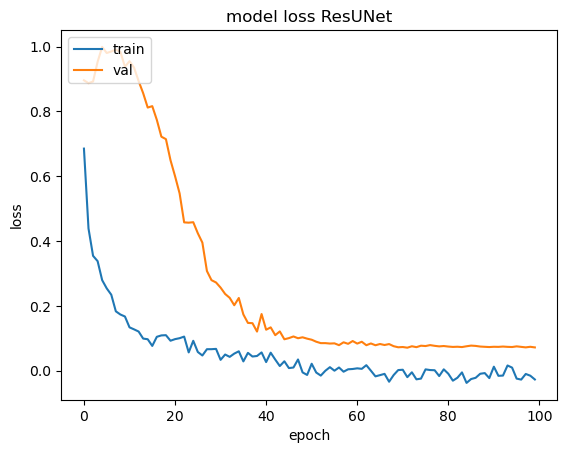

In [6]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss ResUNet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


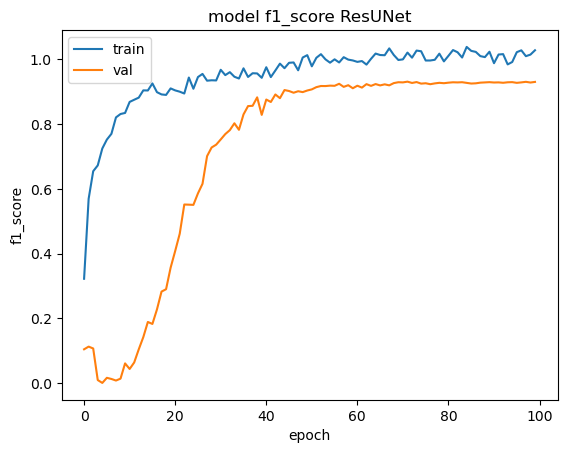

In [7]:
# summarize history for F1

plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1_score ResUNet')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


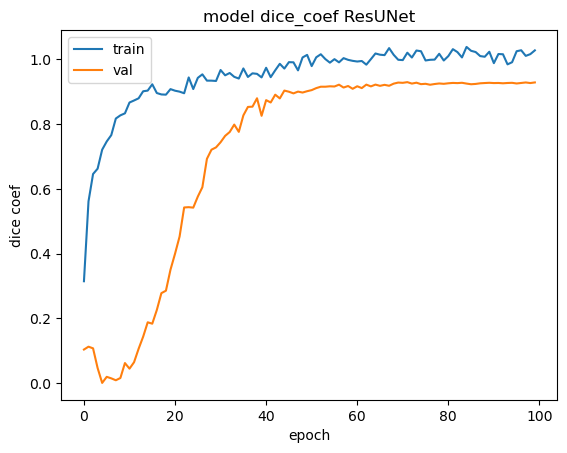

In [8]:
# summarize history for dice_coef

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coef ResUNet')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [5]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256,batch_size=128, shuffle=True)
model = ResUNet()
model.load_weights(r'C:\TUsimple_ResUNet\model')
model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = model.evaluate(val_generator,batch_size= 60, verbose=1,)

4/4 [==============================] - 22s 3s/step - loss: 0.0349 - f1: 0.9673 - iou: 0.9635 - dice_coef: 0.9652


In [9]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\testing", img_size=256,batch_size=128, shuffle=False)
X, y = val_generator.__getitem__(0)
predict = model.predict(X)

4/4 [==============================] - 2s 189ms/step


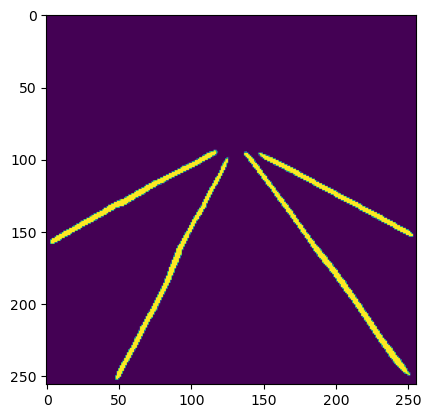

In [10]:
img = predict[2]
plt.imshow(img)

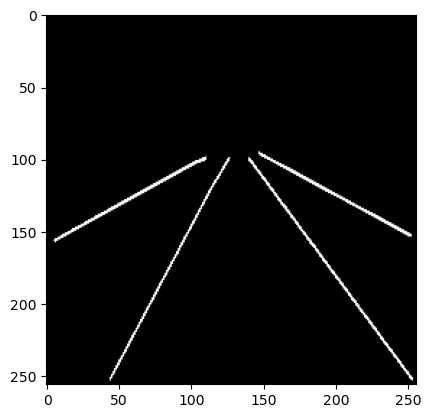

In [11]:
plt.imshow(y[2])

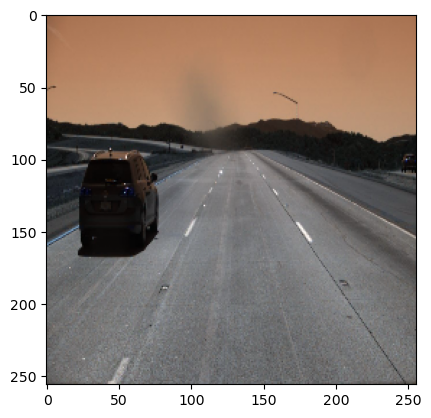

In [12]:
plt.imshow(X[2])